In [4]:
# YOLOv7-Like Model Using Quantum-Train for CIFAR-10

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import numpy as np
import torch.optim as optim
import time

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/media/PhD/miniconda3/envs/tqtest/lib/python3.9/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [1]:
# Quantum YOLOv7 Using Quantum-Train on CIFAR-10
##############################################
# Quantum Train Components
##############################################

class QLayer(nn.Module):
    def __init__(self, n_blocks, n_qubit):
        super().__init__()
        import torchquantum as tq
        self.n_wires = n_qubit
        self.u3_layers = tq.QuantumModuleList()
        self.cu3_layers = tq.QuantumModuleList()
        for _ in range(n_blocks):
            self.u3_layers.append(tq.Op1QAllLayer(op=tq.U3, n_wires=self.n_wires, has_params=True, trainable=True))
            self.cu3_layers.append(tq.Op2QAllLayer(op=tq.CU3, n_wires=self.n_wires, has_params=True, trainable=True, circular=True))

    def forward(self):
        import torchquantum as tq
        qdev = tq.QuantumDevice(n_wires=self.n_wires, bsz=1, device=next(self.parameters()).device)
        for u3, cu3 in zip(self.u3_layers, self.cu3_layers):
            u3(qdev)
            cu3(qdev)
        state = qdev.get_states_1d().abs()[0]
        return state ** 2

class MappingModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        self.hidden_layers = nn.ModuleList([nn.Sequential(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.ReLU()) for i in range(len(hidden_sizes)-1)])
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        x = x.type_as(self.input_layer.weight)
        x = F.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

def generate_qubit_states(n_qubit):
    return torch.cartesian_prod(*[torch.tensor([-1, 1]) for _ in range(n_qubit)])

/media/PhD/miniconda3/envs/tqtest/lib/python3.9/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
##############################################
# Training on CIFAR-10
##############################################

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [40]:


##############################################
# QT-Enhanced Conv Layer
##############################################

class QTConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, k=3, s=1, p=1, qnn=None, mapper=None):
        super().__init__()
        self.k, self.s, self.p = k, s, p
        self.in_channels, self.out_channels = in_channels, out_channels
        self.qnn = qnn
        self.mapper = mapper
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        num_params = self.out_channels * self.in_channels * self.k * self.k
        probs = self.qnn()[:num_params].reshape(-1, 1)
        n_qubit = int(np.ceil(np.log2(len(probs))))
        states = generate_qubit_states(n_qubit).to(x.device)[:len(probs)]
        combined = torch.cat((states, probs), dim=1).reshape(len(probs), -1)
        weights = self.mapper(combined)
        if weights.numel() != self.out_channels * self.in_channels * self.k * self.k:
            weights = weights[:self.out_channels * self.in_channels * self.k * self.k]
        weights = weights.flatten()[:self.out_channels * self.in_channels * self.k * self.k]
        expected_shape = self.out_channels * self.in_channels * self.k * self.k
        if weights.numel() < expected_shape:
            padding = expected_shape - weights.numel()
            weights = F.pad(weights.flatten(), (0, padding))
        else:
            weights = weights.flatten()[:expected_shape]
        weights = weights.view(self.out_channels, self.in_channels, self.k, self.k)
        x = F.conv2d(x, weights.to(x.dtype), bias=None, stride=self.s, padding=self.p)
        x = self.bn(x)
        return self.relu(x)

##############################################
# YOLOv7-Like Quantum Backbone
##############################################

class QuantumYOLOv7Backbone(nn.Module):
    def __init__(self, qnn, mapper):
        super().__init__()
        self.layer1 = QTConvBlock(3, 32, qnn=qnn, mapper=mapper)
        self.layer2 = QTConvBlock(32, 64, s=2, qnn=qnn, mapper=mapper)
        self.layer3 = QTConvBlock(64, 128, s=2, qnn=qnn, mapper=mapper)
        self.layer4 = QTConvBlock(128, 256, s=2, qnn=qnn, mapper=mapper)

    def forward(self, x):
        for layer in [self.layer1, self.layer2, self.layer3, self.layer4]:
            x = layer(x)
        return x

class QuantumYOLOv7Head(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels // 2, 1)
        self.out = nn.Conv2d(in_channels // 2, num_classes, 1)

    def forward(self, x):
        return self.out(F.relu(self.conv(x)))

class QuantumYOLOv7(nn.Module):
    def __init__(self, num_classes, qnn, mapper):
        super().__init__()
        self.backbone = QuantumYOLOv7Backbone(qnn, mapper)
        self.head = QuantumYOLOv7Head(256, num_classes)

    def forward(self, x):
        return self.head(self.backbone(x))



n_qubit = 10
qnn = QLayer(n_blocks=5, n_qubit=n_qubit).to(device)
mapper = MappingModel(input_size=n_qubit+1, hidden_sizes=[64, 128, 64], output_size=1).to(device)
model = QuantumYOLOv7(num_classes=10, qnn=qnn, mapper=mapper).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct, total = 0, 0
    for i, (inputs, labels) in enumerate(trainloader):
        since_batch = time.time()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).mean([2, 3])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += outputs.argmax(dim=1).eq(labels).sum().item()
        total += labels.size(0)
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}, batch time: {time.time() - since_batch:.2f}, correct:  {(correct):.2f}%")


    acc = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {acc:.2f}%")


Epoch [1/2], Step [1/782], Loss: 2.3026, batch time: 0.18, correct:  5.00%
Epoch [1/2], Step [2/782], Loss: 2.2990, batch time: 0.20, correct:  13.00%
Epoch [1/2], Step [3/782], Loss: 2.3047, batch time: 0.20, correct:  20.00%
Epoch [1/2], Step [4/782], Loss: 2.3075, batch time: 0.21, correct:  28.00%
Epoch [1/2], Step [5/782], Loss: 2.3080, batch time: 0.20, correct:  34.00%
Epoch [1/2], Step [6/782], Loss: 2.2968, batch time: 0.24, correct:  40.00%
Epoch [1/2], Step [7/782], Loss: 2.2930, batch time: 0.39, correct:  42.00%
Epoch [1/2], Step [8/782], Loss: 2.3116, batch time: 0.39, correct:  48.00%
Epoch [1/2], Step [9/782], Loss: 2.3001, batch time: 0.37, correct:  54.00%
Epoch [1/2], Step [10/782], Loss: 2.2993, batch time: 0.24, correct:  59.00%
Epoch [1/2], Step [11/782], Loss: 2.2912, batch time: 0.21, correct:  67.00%
Epoch [1/2], Step [12/782], Loss: 2.3031, batch time: 0.18, correct:  74.00%
Epoch [1/2], Step [13/782], Loss: 2.3024, batch time: 0.19, correct:  78.00%
Epoch [1/

In [41]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 52855


In [46]:
numpy_weights = {}
nw_list = [] 
nw_list_normal = []
name_list = [] 
for name, param in model.state_dict().items():
    name_list.append(name)
    print(name)
    numpy_weights[name] = param.cpu().numpy()
for i in numpy_weights:
    nw_list.append(list(numpy_weights[i].flatten()))
for i in nw_list:
    for j in i:
        nw_list_normal.append(j)
print("# of QNN parameters: ", len(nw_list_normal))


backbone.layer1.qnn.u3_layers.0.ops_all.0.params
backbone.layer1.qnn.u3_layers.0.ops_all.1.params
backbone.layer1.qnn.u3_layers.0.ops_all.2.params
backbone.layer1.qnn.u3_layers.0.ops_all.3.params
backbone.layer1.qnn.u3_layers.0.ops_all.4.params
backbone.layer1.qnn.u3_layers.0.ops_all.5.params
backbone.layer1.qnn.u3_layers.0.ops_all.6.params
backbone.layer1.qnn.u3_layers.0.ops_all.7.params
backbone.layer1.qnn.u3_layers.0.ops_all.8.params
backbone.layer1.qnn.u3_layers.0.ops_all.9.params
backbone.layer1.qnn.u3_layers.1.ops_all.0.params
backbone.layer1.qnn.u3_layers.1.ops_all.1.params
backbone.layer1.qnn.u3_layers.1.ops_all.2.params
backbone.layer1.qnn.u3_layers.1.ops_all.3.params
backbone.layer1.qnn.u3_layers.1.ops_all.4.params
backbone.layer1.qnn.u3_layers.1.ops_all.5.params
backbone.layer1.qnn.u3_layers.1.ops_all.6.params
backbone.layer1.qnn.u3_layers.1.ops_all.7.params
backbone.layer1.qnn.u3_layers.1.ops_all.8.params
backbone.layer1.qnn.u3_layers.1.ops_all.9.params
backbone.layer1.qnn.

Test Accuracy: 19.23%
Classification Report:
              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1000
  automobile       0.12      0.33      0.17      1000
        bird       0.12      0.07      0.08      1000
         cat       0.17      0.12      0.14      1000
        deer       0.15      0.07      0.09      1000
         dog       0.19      0.02      0.04      1000
        frog       0.24      0.54      0.34      1000
       horse       0.00      0.00      0.00      1000
        ship       0.25      0.78      0.38      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.19     10000
   macro avg       0.12      0.19      0.12     10000
weighted avg       0.12      0.19      0.12     10000



/media/PhD/miniconda3/envs/tqtest/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/PhD/miniconda3/envs/tqtest/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/PhD/miniconda3/envs/tqtest/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

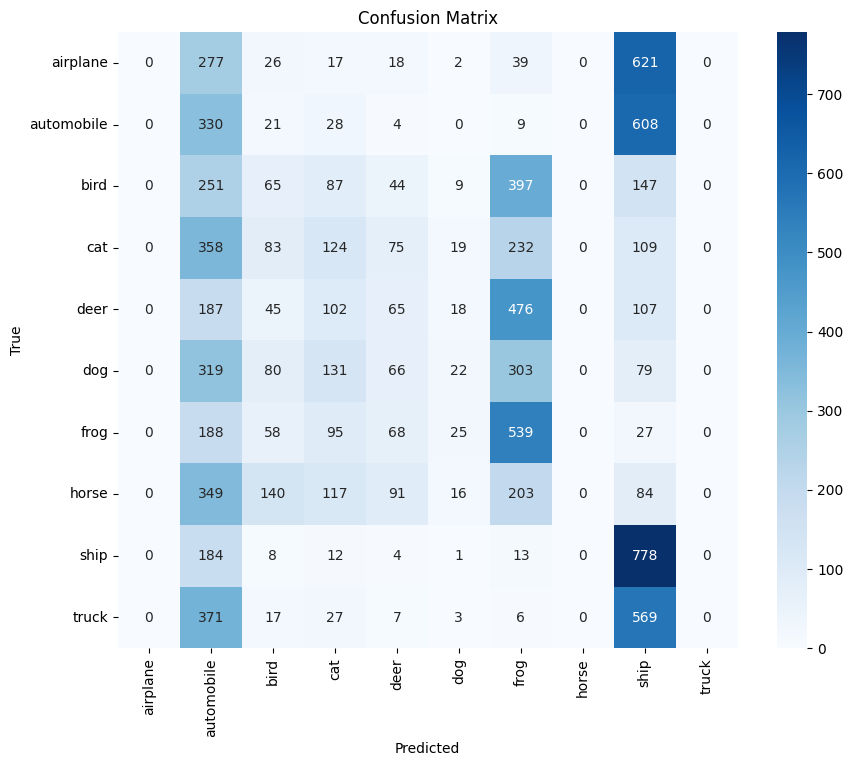

In [34]:
# Evaluation on CIFAR-10 test set
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

all_preds = []
all_labels = []
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).mean([2, 3])
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=trainset.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [35]:
#!pip install seaborn

Epoch [1/2], Step [782/782], Loss: 2.3081, correct:  3.00%
Epoch [1/2], Step [782/782], Loss: 2.2604, correct:  14.00%
Epoch [1/2], Step [782/782], Loss: 2.2205, correct:  29.00%
Epoch [1/2], Step [782/782], Loss: 2.1907, correct:  41.00%
Epoch [1/2], Step [782/782], Loss: 2.1458, correct:  58.00%
Epoch [1/2], Step [782/782], Loss: 2.0862, correct:  74.00%
Epoch [1/2], Step [782/782], Loss: 2.1422, correct:  90.00%
Epoch [1/2], Step [782/782], Loss: 2.1436, correct:  105.00%
Epoch [1/2], Step [782/782], Loss: 2.1695, correct:  118.00%
Epoch [1/2], Step [782/782], Loss: 2.1469, correct:  128.00%
Epoch [1/2], Step [782/782], Loss: 2.1628, correct:  137.00%
Epoch [1/2], Step [782/782], Loss: 1.9442, correct:  157.00%
Epoch [1/2], Step [782/782], Loss: 1.9975, correct:  171.00%
Epoch [1/2], Step [782/782], Loss: 2.0509, correct:  185.00%
Epoch [1/2], Step [782/782], Loss: 1.9412, correct:  202.00%
Epoch [1/2], Step [782/782], Loss: 1.9826, correct:  215.00%
Epoch [1/2], Step [782/782], Los

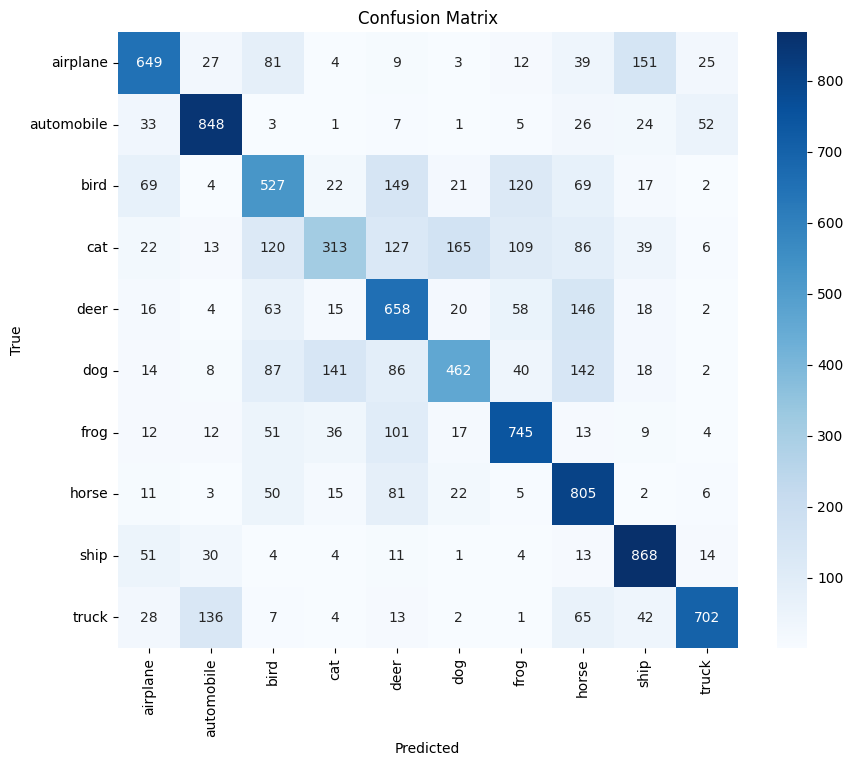

In [42]:
# (Appended below)

# Classical YOLOv7-like model for comparison
class ClassicalConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, k=3, s=1, p=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, k, s, p, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class ClassicalYOLOv7Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = ClassicalConvBlock(3, 32)
        self.layer2 = ClassicalConvBlock(32, 64, s=2)
        self.layer3 = ClassicalConvBlock(64, 128, s=2)
        self.layer4 = ClassicalConvBlock(128, 256, s=2)

    def forward(self, x):
        for layer in [self.layer1, self.layer2, self.layer3, self.layer4]:
            x = layer(x)
        return x

class ClassicalYOLOv7Head(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels // 2, 1)
        self.out = nn.Conv2d(in_channels // 2, num_classes, 1)

    def forward(self, x):
        return self.out(F.relu(self.conv(x)))

class ClassicalYOLOv7(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = ClassicalYOLOv7Backbone()
        self.head = ClassicalYOLOv7Head(256, num_classes)

    def forward(self, x):
        return self.head(self.backbone(x))

# Train and evaluate classical model
model_classical = ClassicalYOLOv7(num_classes=10).to(device)
optimizer_classical = optim.Adam(model_classical.parameters(), lr=0.001)

for epoch in range(2):
    model_classical.train()
    total_loss = 0
    correct, total = 0, 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_classical.zero_grad()
        outputs = model_classical(inputs).mean([2, 3])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_classical.step()

        total_loss += loss.item()
        correct += outputs.argmax(dim=1).eq(labels).sum().item()
        total += labels.size(0)
        print(f"Epoch [{epoch+1}/{2}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}, correct:  {(correct):.2f}%")


    acc = 100 * correct / total
    print(f"[Classical] Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {acc:.2f}%")

# Evaluation on CIFAR-10 test set with metrics
model_classical.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_classical(inputs).mean([2, 3])
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print(f"Test Accuracy: {accuracy:.2f}%")

all_preds = []
all_labels = []
model_classical.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_classical(inputs).mean([2, 3])
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=trainset.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [43]:
total_params = count_parameters(model_classical)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 423082


In [44]:
numpy_weights = {}
nw_list = [] 
nw_list_normal = []
name_list = [] 
for name, param in model_classical.state_dict().items():
    name_list.append(name)
    print(name)
    numpy_weights[name] = param.cpu().numpy()
for i in numpy_weights:
    nw_list.append(list(numpy_weights[i].flatten()))
for i in nw_list:
    for j in i:
        nw_list_normal.append(j)
print("# of NN parameters: ", len(nw_list_normal))
n_qubits = int(np.ceil(np.log2(len(nw_list_normal))))
print("Required qubit number: ", n_qubits)

backbone.layer1.block.0.weight
backbone.layer1.block.1.weight
backbone.layer1.block.1.bias
backbone.layer1.block.1.running_mean
backbone.layer1.block.1.running_var
backbone.layer1.block.1.num_batches_tracked
backbone.layer2.block.0.weight
backbone.layer2.block.1.weight
backbone.layer2.block.1.bias
backbone.layer2.block.1.running_mean
backbone.layer2.block.1.running_var
backbone.layer2.block.1.num_batches_tracked
backbone.layer3.block.0.weight
backbone.layer3.block.1.weight
backbone.layer3.block.1.bias
backbone.layer3.block.1.running_mean
backbone.layer3.block.1.running_var
backbone.layer3.block.1.num_batches_tracked
backbone.layer4.block.0.weight
backbone.layer4.block.1.weight
backbone.layer4.block.1.bias
backbone.layer4.block.1.running_mean
backbone.layer4.block.1.running_var
backbone.layer4.block.1.num_batches_tracked
head.conv.weight
head.conv.bias
head.out.weight
head.out.bias
# of NN parameters:  424046
Required qubit number:  19


In [7]:
#new version of YOLOV7
# (Appended below)

# Classical YOLOv7-like model for comparison
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, k=3, s=1, p=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, k, s, p, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class CSPBlock(nn.Module):
    def __init__(self, channels, num_blocks=1):
        super(CSPBlock, self).__init__()
        self.blocks = nn.Sequential(
            *[ConvBlock(channels, channels) for _ in range(num_blocks)]
        )
    def forward(self, x):
        return x + self.blocks(x)

class YOLOv7Backbone(nn.Module):
    def __init__(self):
        super(YOLOv7Backbone, self).__init__()
        self.layer1 = ConvBlock(3, 32, 3, 1)
        self.layer2 = ConvBlock(32, 64, 3, 2)
        self.csp1 = CSPBlock(64, 2)
        self.layer3 = ConvBlock(64, 128, 3, 2)
        self.csp2 = CSPBlock(128, 2)
        self.layer4 = ConvBlock(128, 256, 3, 2)
        self.csp3 = CSPBlock(256, 2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.csp1(x)
        x = self.layer3(x)
        x = self.csp2(x)
        x = self.layer4(x)
        x = self.csp3(x)
        return x

class YOLOv7Head(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(YOLOv7Head, self).__init__()
        self.head = nn.Sequential(
            ConvBlock(in_channels, in_channels // 2),
            nn.Conv2d(in_channels // 2, num_classes + 5, 1)  # class scores + bbox (x, y, w, h, conf)
        )
    def forward(self, x):
        return self.head(x)

class YOLOv7Simple(nn.Module):
    def __init__(self, num_classes):
        super(YOLOv7Simple, self).__init__()
        self.backbone = YOLOv7Backbone()
        self.head = YOLOv7Head(256, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        outputs = self.head(features)
        return outputs

Epoch [0/2], Step [1/782], Loss: 2.6920, Accuracy:  15.62%
Epoch [0/2], Step [2/782], Loss: 2.5574, Accuracy:  18.75%
Epoch [0/2], Step [3/782], Loss: 2.3898, Accuracy:  21.35%
Epoch [0/2], Step [4/782], Loss: 2.5494, Accuracy:  20.31%
Epoch [0/2], Step [5/782], Loss: 2.3400, Accuracy:  20.31%
Epoch [0/2], Step [6/782], Loss: 2.2543, Accuracy:  21.35%
Epoch [0/2], Step [7/782], Loss: 2.3493, Accuracy:  20.09%
Epoch [0/2], Step [8/782], Loss: 2.3312, Accuracy:  20.70%
Epoch [0/2], Step [9/782], Loss: 2.2395, Accuracy:  21.35%
Epoch [0/2], Step [10/782], Loss: 2.2297, Accuracy:  21.25%
Epoch [0/2], Step [11/782], Loss: 2.1515, Accuracy:  21.31%
Epoch [0/2], Step [12/782], Loss: 2.1056, Accuracy:  22.01%
Epoch [0/2], Step [13/782], Loss: 2.0322, Accuracy:  22.48%
Epoch [0/2], Step [14/782], Loss: 2.0796, Accuracy:  22.54%
Epoch [0/2], Step [15/782], Loss: 2.0150, Accuracy:  23.02%
Epoch [0/2], Step [16/782], Loss: 2.0830, Accuracy:  23.14%
Epoch [0/2], Step [17/782], Loss: 2.0263, Accurac

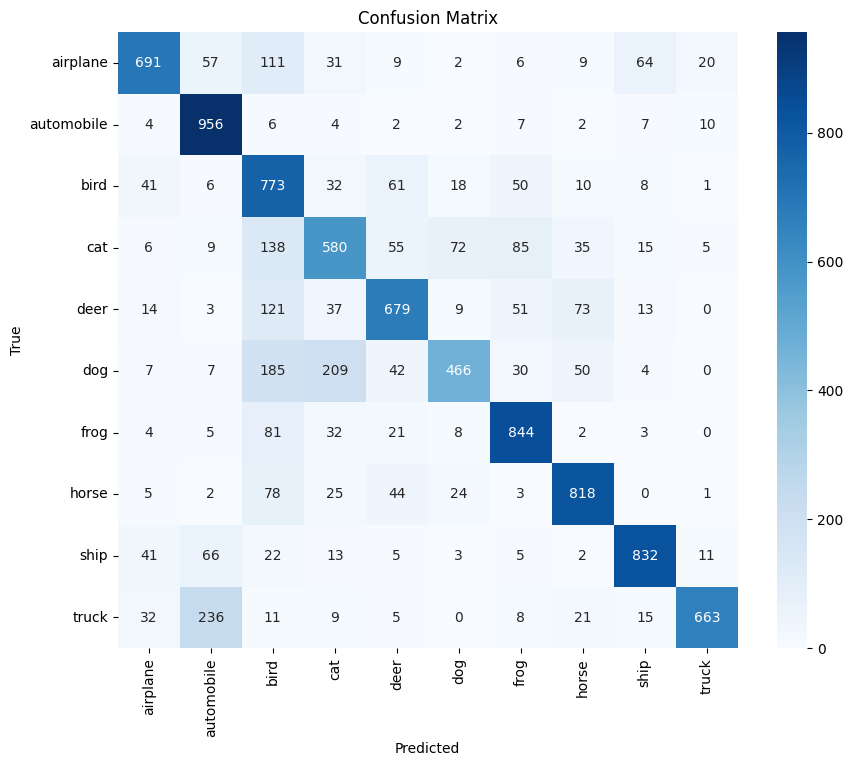

In [57]:

# Train and evaluate classical YOLOv7Simple model
model_classical = YOLOv7Simple(num_classes=10).to(device)
optimizer_classical = optim.Adam(model_classical.parameters(), lr=0.001)

for epoch in range(2):
    model_classical.train()
    total_loss = 0
    correct, total = 0, 0
    for i,(inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_classical.zero_grad()
        outputs = model_classical(inputs).mean([2, 3])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_classical.step()

        total_loss += loss.item()
        correct += outputs.argmax(dim=1).eq(labels).sum().item()
        total += labels.size(0)
        print(f"Epoch [{epoch}/{2}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}, Accuracy:  {(100 * correct / total):.2f}%")


    acc = 100 * correct / total
    print(f"[Classical YOLOv7] Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {acc:.2f}%")

# Evaluation on CIFAR-10 test set with metrics
model_classical.eval()
correct, total = 0, 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_classical(inputs).mean([2, 3])
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=trainset.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [56]:
numpy_weights = {}
nw_list = [] 
nw_list_normal = []
name_list = [] 
for name, param in model_classical.state_dict().items():
    name_list.append(name)
    print(name)
    numpy_weights[name] = param.cpu().numpy()
for i in numpy_weights:
    nw_list.append(list(numpy_weights[i].flatten()))
for i in nw_list:
    for j in i:
        nw_list_normal.append(j)
print("# of NN parameters: ", len(nw_list_normal))
n_qubits = int(np.ceil(np.log2(len(nw_list_normal))))
print("Required qubit number: ", n_qubits)

backbone.layer1.conv.0.weight
backbone.layer1.conv.1.weight
backbone.layer1.conv.1.bias
backbone.layer1.conv.1.running_mean
backbone.layer1.conv.1.running_var
backbone.layer1.conv.1.num_batches_tracked
backbone.layer2.conv.0.weight
backbone.layer2.conv.1.weight
backbone.layer2.conv.1.bias
backbone.layer2.conv.1.running_mean
backbone.layer2.conv.1.running_var
backbone.layer2.conv.1.num_batches_tracked
backbone.csp1.blocks.0.conv.0.weight
backbone.csp1.blocks.0.conv.1.weight
backbone.csp1.blocks.0.conv.1.bias
backbone.csp1.blocks.0.conv.1.running_mean
backbone.csp1.blocks.0.conv.1.running_var
backbone.csp1.blocks.0.conv.1.num_batches_tracked
backbone.csp1.blocks.1.conv.0.weight
backbone.csp1.blocks.1.conv.1.weight
backbone.csp1.blocks.1.conv.1.bias
backbone.csp1.blocks.1.conv.1.running_mean
backbone.csp1.blocks.1.conv.1.running_var
backbone.csp1.blocks.1.conv.1.num_batches_tracked
backbone.layer3.conv.0.weight
backbone.layer3.conv.1.weight
backbone.layer3.conv.1.bias
backbone.layer3.conv

In [ ]:
# bigger architecture


# Quantum-Train-enhanced YOLOv7 architecture

# Calculate number of qubits needed for quantum training
nw_list_normal = []
dummy_model = YOLOv7Simple(num_classes=10).to(device)
numpy_weights = {name: param.cpu().detach().numpy() for name, param in dummy_model.state_dict().items()}
for layer in numpy_weights.values():
    nw_list_normal.extend(layer.flatten())
n_qubits = int(np.ceil(np.log2(len(nw_list_normal))))
print(f"Total parameters: {len(nw_list_normal)} | Required qubits: {n_qubits}")

# Quantum-Train Conv Block for replacement
class QTConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, k=3, s=1, p=1, qnn=None, mapper=None):
        super().__init__()
        self.k, self.s, self.p = k, s, p
        self.in_channels, self.out_channels = in_channels, out_channels
        self.qnn = qnn
        self.mapper = mapper
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        n_params = self.out_channels * self.in_channels * self.k * self.k
        probs = self.qnn()[:n_params].reshape(-1, 1)
        states = generate_qubit_states(n_qubits).to(x.device)[:n_params]
        combined = torch.cat((states, probs), dim=1).reshape(n_params, -1)
        weights = self.mapper(combined)
        if weights.numel() < n_params:
            weights = F.pad(weights.flatten(), (0, n_params - weights.numel()))
        else:
            weights = weights.flatten()[:n_params]
        weights = weights.view(self.out_channels, self.in_channels, self.k, self.k)
        x = F.conv2d(x, weights.to(x.dtype), bias=None, stride=self.s, padding=self.p)
        return self.relu(self.bn(x))

# Replace ConvBlock with QTConvBlock in YOLOv7Backbone
class YOLOv7BackboneQT(nn.Module):
    def __init__(self, qnn, mapper):
        super().__init__()
        self.layer1 = QTConvBlock(3, 32, 3, 1, qnn=qnn, mapper=mapper)
        self.layer2 = QTConvBlock(32, 64, 3, 2, qnn=qnn, mapper=mapper)
        self.csp1 = nn.Sequential(*[QTConvBlock(64, 64, 3, 1, qnn=qnn, mapper=mapper) for _ in range(2)])
        self.layer3 = QTConvBlock(64, 128, 3, 2, qnn=qnn, mapper=mapper)
        self.csp2 = nn.Sequential(*[QTConvBlock(128, 128, 3, 1, qnn=qnn, mapper=mapper) for _ in range(2)])
        self.layer4 = QTConvBlock(128, 256, 3, 2, qnn=qnn, mapper=mapper)
        self.csp3 = nn.Sequential(*[QTConvBlock(256, 256, 3, 1, qnn=qnn, mapper=mapper) for _ in range(2)])

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x + self.csp1(x)
        x = self.layer3(x)
        x = x + self.csp2(x)
        x = self.layer4(x)
        x = x + self.csp3(x)
        return x

# Complete QT YOLOv7
class YOLOv7SimpleQT(nn.Module):
    def __init__(self, num_classes, qnn, mapper):
        super().__init__()
        self.backbone = YOLOv7BackboneQT(qnn=qnn, mapper=mapper)
        self.head = YOLOv7Head(256, num_classes)

    def forward(self, x):
        return self.head(self.backbone(x))

# Instantiate QNN and mapper
qnn = QLayer(n_blocks=5, n_qubit=n_qubits).to(device)
mapper = MappingModel(input_size=n_qubits + 1, hidden_sizes=[64, 128, 64], output_size=1).to(device)

model_qt = YOLOv7SimpleQT(num_classes=10, qnn=qnn, mapper=mapper).to(device)
optimizer_qt = optim.Adam(model_qt.parameters(), lr=0.001)

# Train QT model
for epoch in range(3):
    model_qt.train()
    total_loss = 0
    correct, total = 0, 0
    for i,(inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_qt.zero_grad()
        outputs = model_qt(inputs).mean([2, 3])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_qt.step()
        total_loss += loss.item()
        correct += outputs.argmax(dim=1).eq(labels).sum().item()
        total += labels.size(0)
        print(f"Epoch [{epoch}/{2}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}, Accuracy:  {(100 * correct / total):.2f}%")

    acc = 100 * correct / total
    print(f"[Quantum YOLOv7] Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {acc:.2f}%")



Total parameters: 2239098 | Required qubits: 22
